In [5]:
import gym
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import copy
from collections import namedtuple, deque
import torch.nn as nn

from model import Actor, Critic
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
import torch.optim as optim


In [6]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.batch_norm = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = torch.relu(self.batch_norm(self.fc1(state)))
        x = torch.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.batch_norm = nn.BatchNorm1d(fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.batch_norm(self.fcs1(state)))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [10]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0#1e-2        # L2 weight decay
LEARN_EVERY = 1
LEARN_NUMBER = 3
EPSILON = 1.0
EPSILON_DECAY = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        
        print("Using: ", device)
        
        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        print("Actor: \n", self.actor_local)
        print("\nCritic: \n", self.critic_local)
        
        # Noise process
        self.noise = OUNoise(action_size, random_seed)
        self.epsilon = EPSILON
        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        

    def step(self, state, action, reward, next_state, done, timestamp):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE and timestamp % LEARN_EVERY == 0:
            for _ in range(LEARN_NUMBER):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)

        assert state.shape == (1,3)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy().squeeze(0)
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample() * self.epsilon
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states.to(device))
        Q_targets_next = self.critic_target(next_states.to(device), actions_next.to(device))
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     
        
        # ----------------------- update epsilon and noise ----------------------- #
        self.epsilon *= EPSILON_DECAY
        self.noise.reset()
    
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [11]:
env = gym.make("Pendulum-v0")
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]

In [12]:
def ddpg(n_episodes=200, max_t=1000, print_every=10):
    scores_deque = deque(maxlen=100)
    scores = []
    minmax_scores = []
    average_100_scores = []
    time_stamp = 0
    for i_episode in range(1, n_episodes+1):

        state = env.reset()                     
        agent.reset()
        score = 0
        for t in range(max_t):
            
            action = agent.act(state)
            
            next_state, reward, done, _ = env.step(action) 
            agent.step(state, action, reward, next_state, done, time_stamp)
            
            
            state = next_state
            score += reward
            time_stamp += 1
            
            if done:
                break 
        
        scores_deque.append(np.mean(score))
        scores.append(np.mean(score))
        minmax_scores.append((np.min(score),np.max(score)))
        average_100_scores.append(np.mean(scores_deque))
        
        print('\rEpisode {}  Min_reward: {:.2f}  Max_reward: {:.2f}  Mean_reward: {:.2f}  Average100 Score: {:.2f}'.format(i_episode,np.min(score),np.max(score),np.mean(score), np.mean(scores_deque)), end="")
        if i_episode % 25 == 0:
            torch.save(agent.actor_local.state_dict(), "checkpoint_actor"+str(i_episode)+".pth")
            torch.save(agent.critic_local.state_dict(), "checkpoint_critic"+str(i_episode)+".pth")
        if i_episode % print_every == 0:
            print('\rEpisode {}  Min_reward: {:.2f}  Max_reward: {:.2f}  Mean_reward: {:.2f}  Average100 Score: {:.2f}'.format(i_episode,np.min(score),np.max(score),np.mean(score), np.mean(scores_deque)))
        if np.mean(scores_deque) >= 30:
            print("\nSolved Environment!")
            torch.save(agent.actor_local.state_dict(), 'final_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'final_critic.pth')
            break
    return scores, minmax_scores, average_100_scores

agent = Agent(state_size=state_size, action_size=action_size, random_seed=1)


scores, minmax, average_100 = ddpg()

    


Using:  cpu
Actor: 
 Actor(
  (fc1): Linear(in_features=3, out_features=400, bias=True)
  (batch_norm): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=400, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)

Critic: 
 Critic(
  (fcs1): Linear(in_features=3, out_features=400, bias=True)
  (batch_norm): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=401, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)
Episode 1  Min_reward: -1421.96  Max_reward: -1421.96  Mean_reward: -1421.96  Average100 Score: -1421.96

KeyboardInterrupt: 

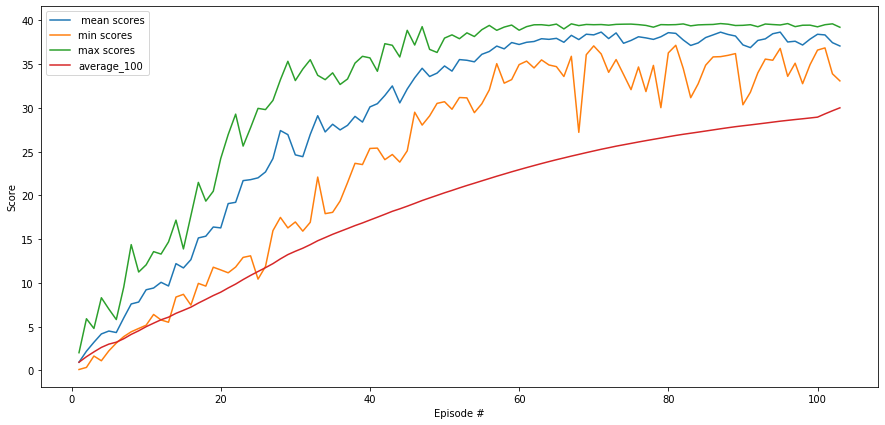

In [24]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label = " mean scores")
plt.plot(np.arange(1, len(minmax)+1), np.array(minmax)[:,0], label = "min scores")
plt.plot(np.arange(1, len(minmax)+1), np.array(minmax)[:,1], label = "max scores")
plt.plot(np.arange(1, len(average_100)+1), average_100, label = "average_100")
plt.legend()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()